In [0]:
# Celda 2 – poner el script en el path de Python
import sys, os, importlib
project_dir = os.getcwd()          # carpeta donde está el notebook
sys.path.append(project_dir)       # añade la ruta para importaciones

# Asegúrate de que el archivo arm_tracing_pipeline.py esté en project_dir
assert os.path.isfile("anchos_pipeline_auto.py"), "⚠️ Script no encontrado"


14:40:30 [INFO] Received command c on object id p0


In [0]:
pip install lmfit==1.3.3

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached lmfit-1.3.3-py3-none-any.whl (100 kB)
  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Using cached uncertainties-3.2.3-py3-none-any.whl (60 kB)
  Using cached dill-0.4.0-py3-none-any.whl (119 kB)
  Using cached asteval-1.0.6-py3-none-any.whl (22 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Not uninstalling numpy at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-708cbdd8-c34c-4718-827d-d6575c4d44ae
    Can't uninstall 'numpy'. No files were found to uninstall.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
# Celda 3 – importar el pipeline como módulo
import anchos_pipeline_auto as atp
importlib.reload(atp)  # por si lo editas y quieres recargar


14:40:34 [INFO] Received command c on object id p0


<module 'anchos_pipeline_auto' from '/Workspace/Users/praciden@crystal.com.co/anchos_pipeline_auto.py'>

14:40:39 [INFO] Received command c on object id p0
14:40:40 [INFO] Halo 11: 8768 puntos en 2 brazos.


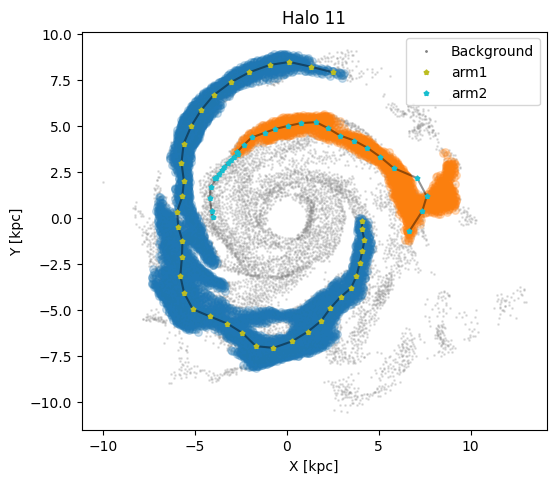

14:40:43 [INFO] Procesando brazo arm1 (37 puntos)...


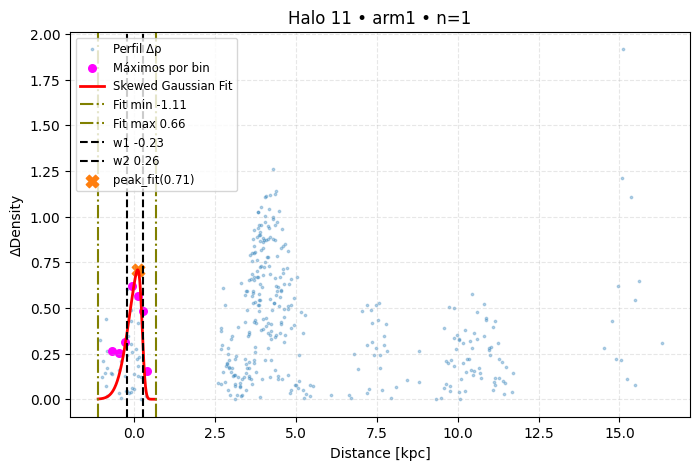

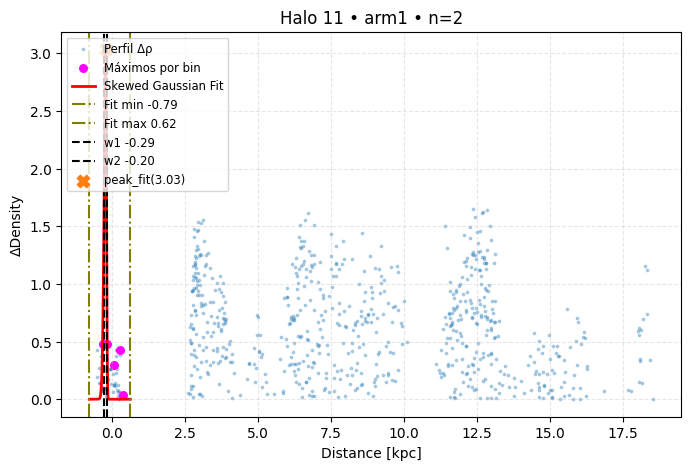

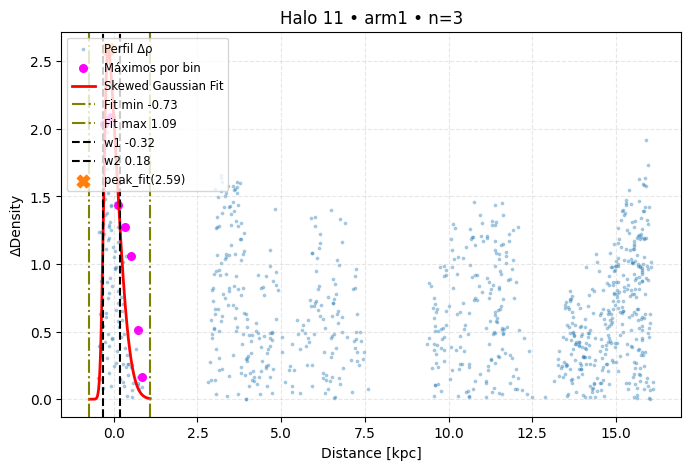

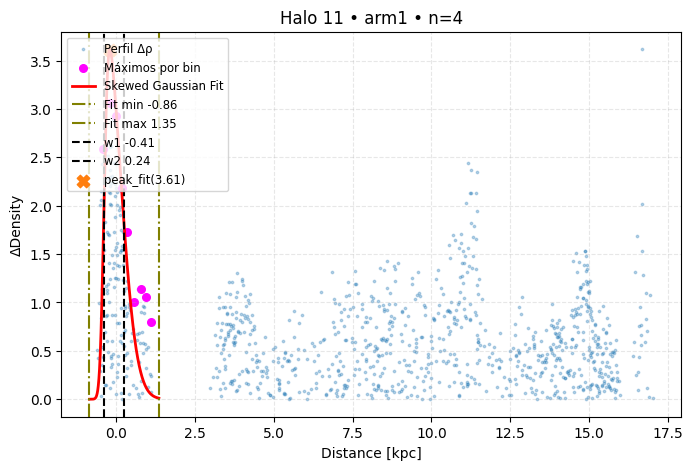

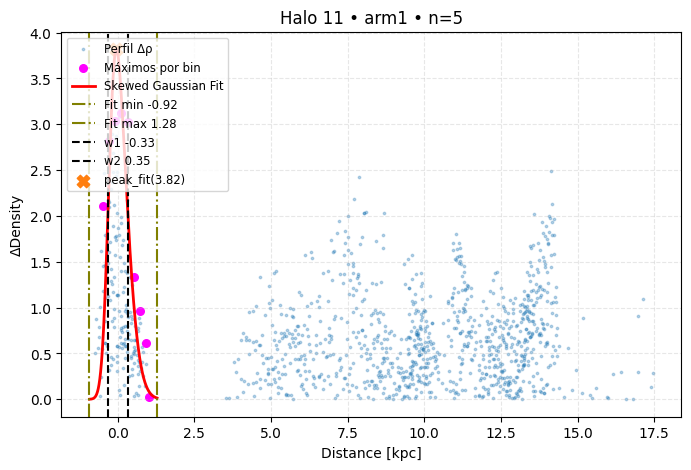

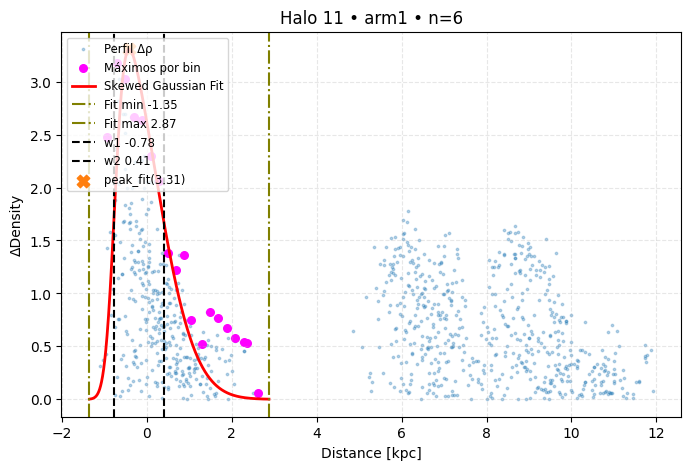

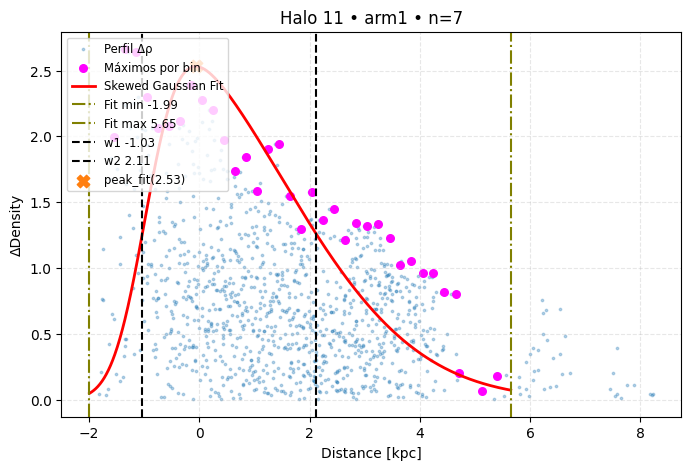

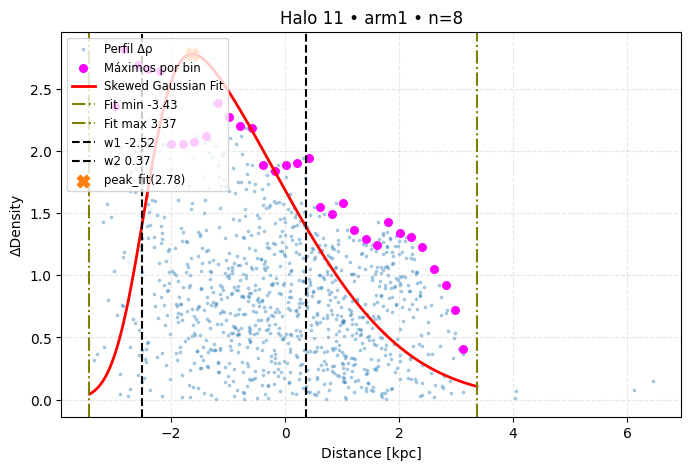

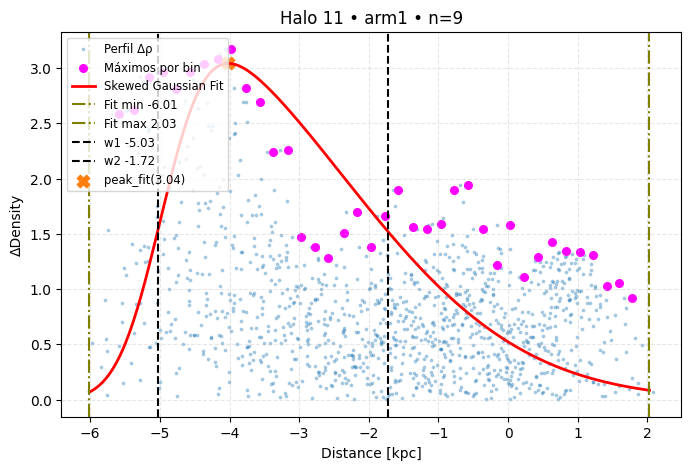

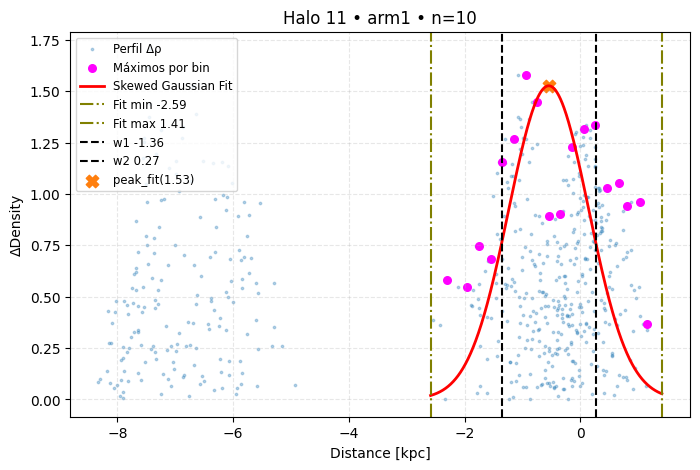

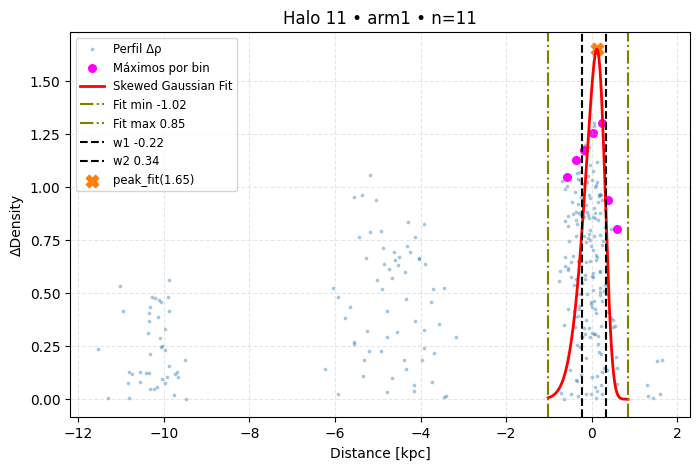

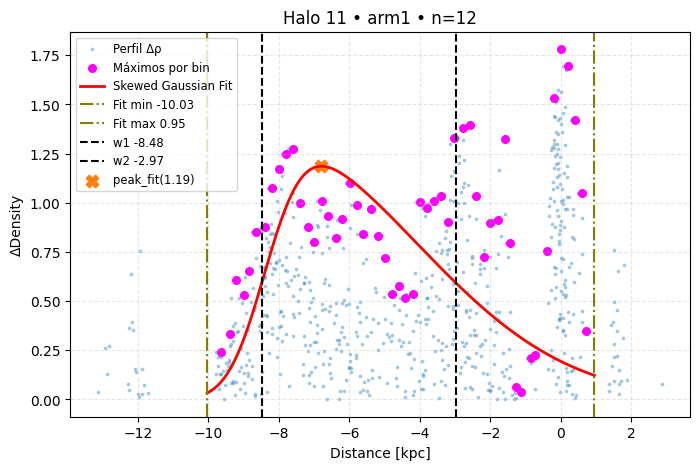

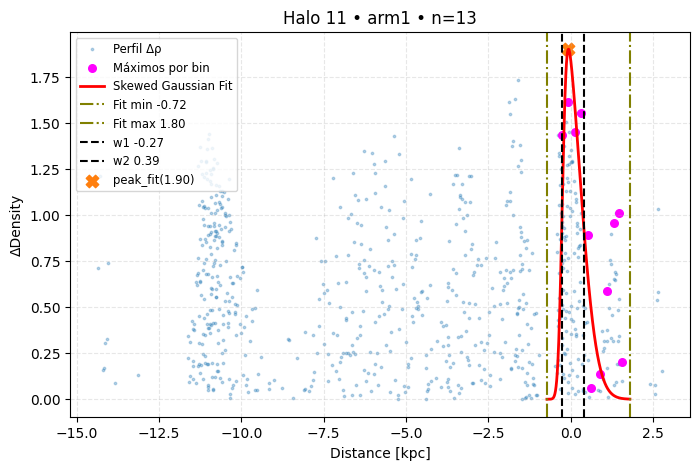

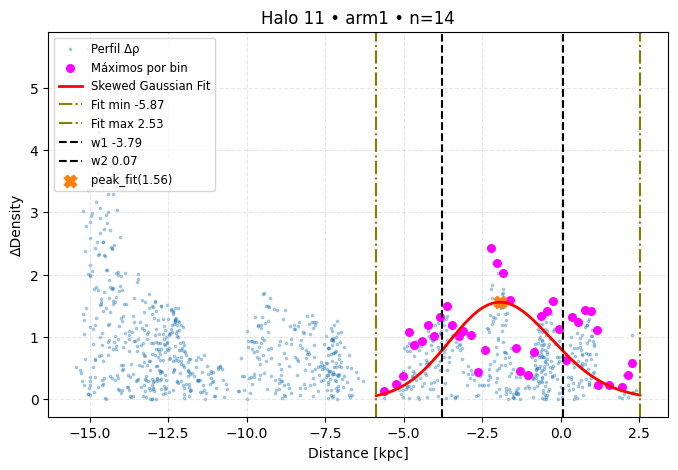

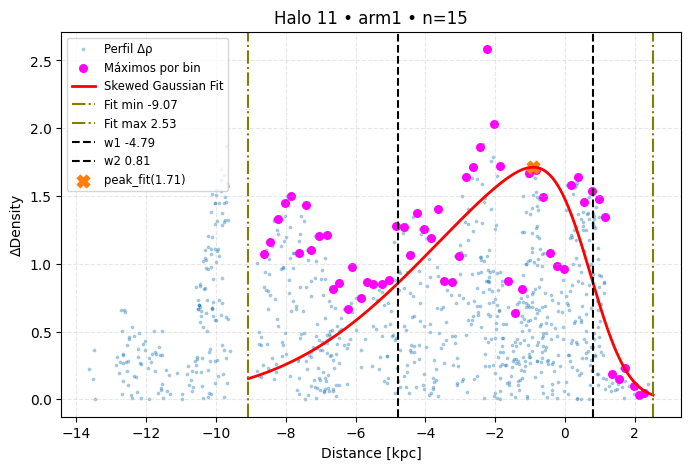

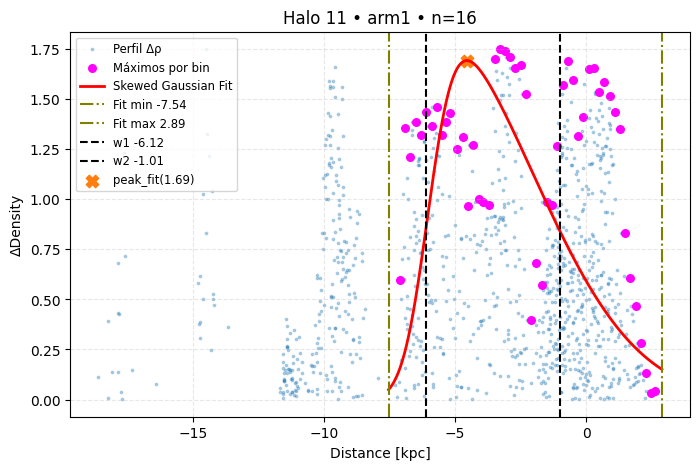

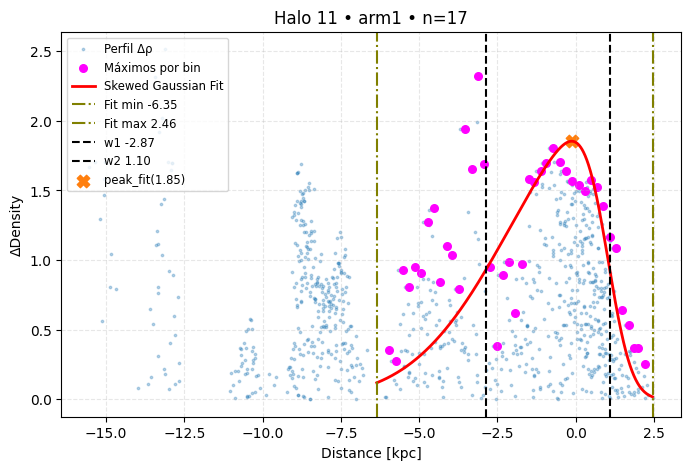

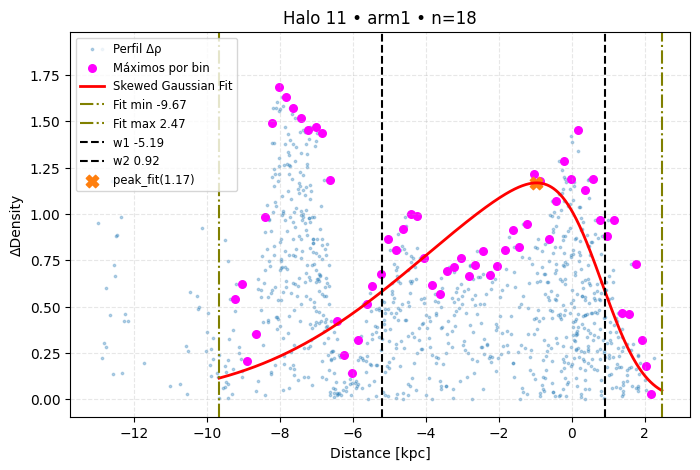

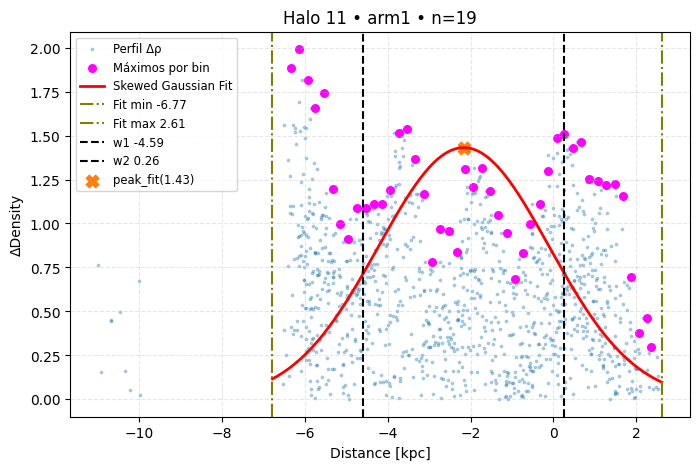

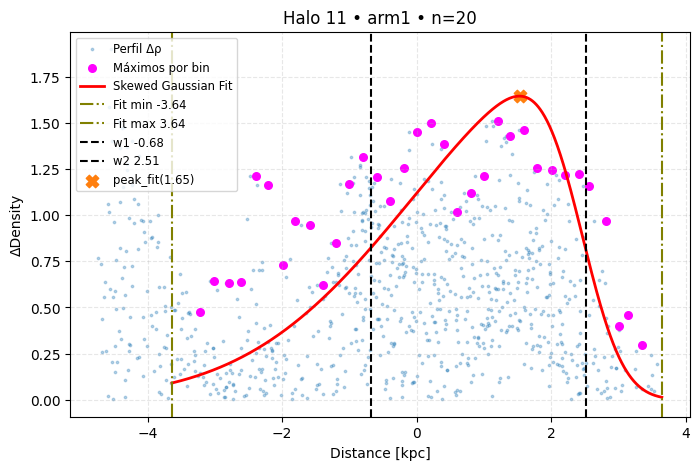

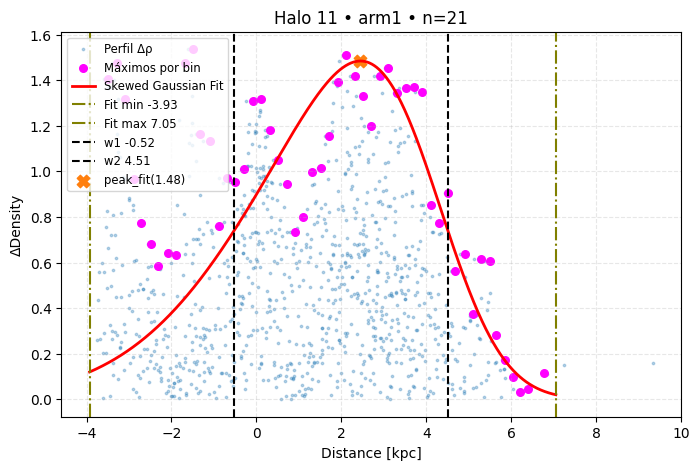

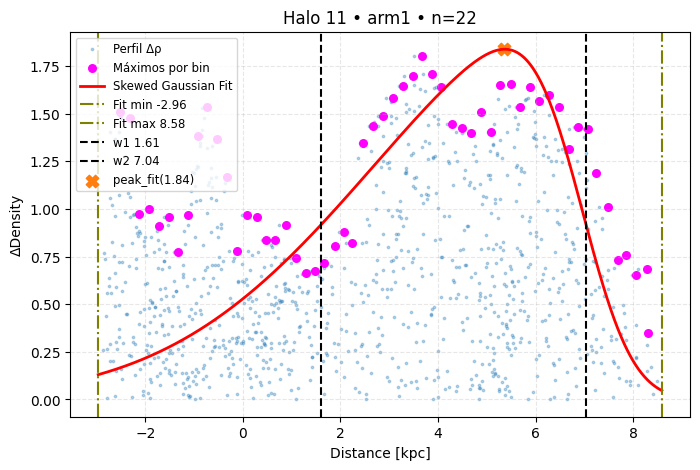

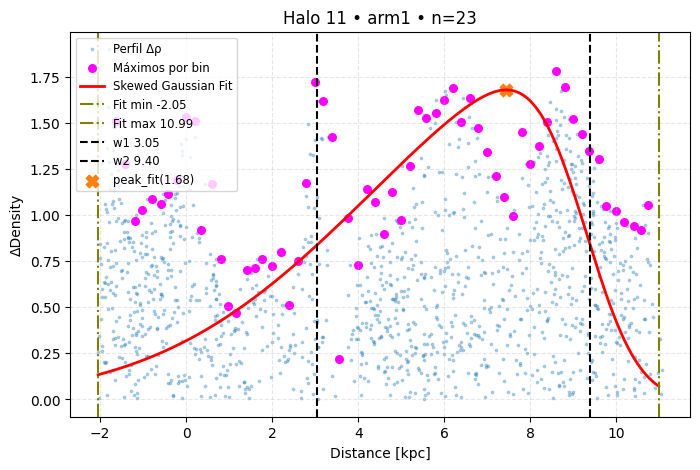

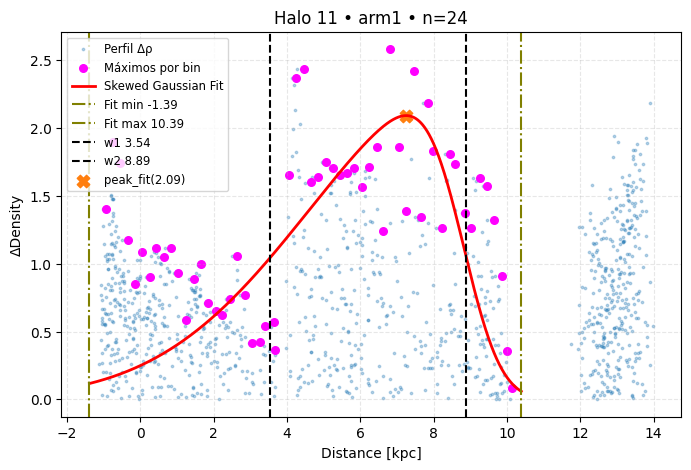

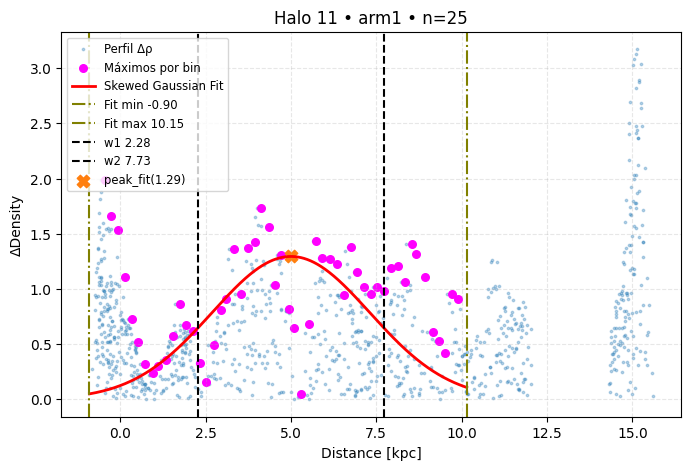

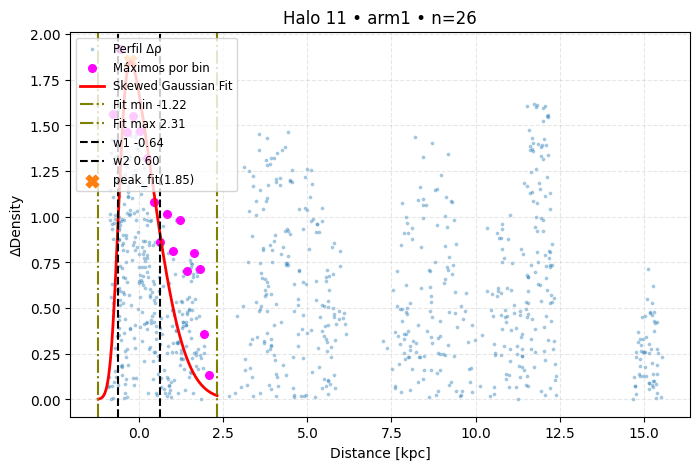

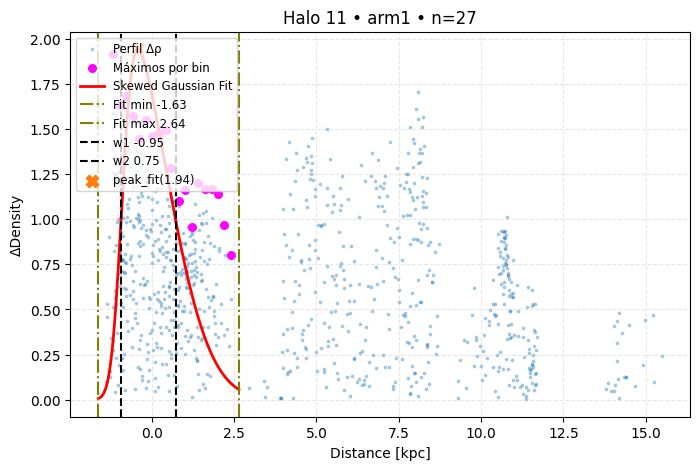

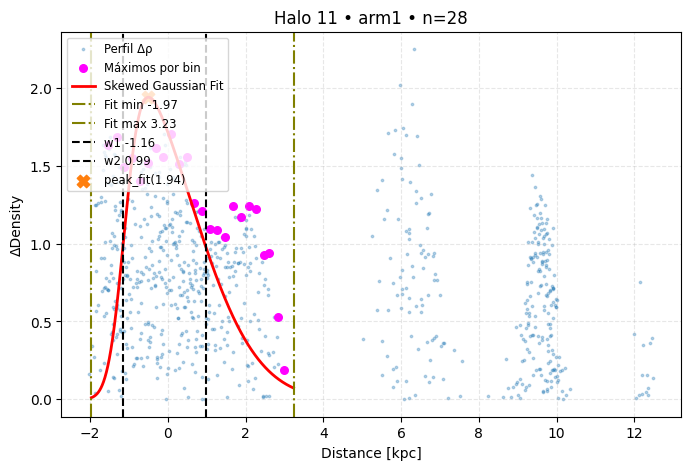

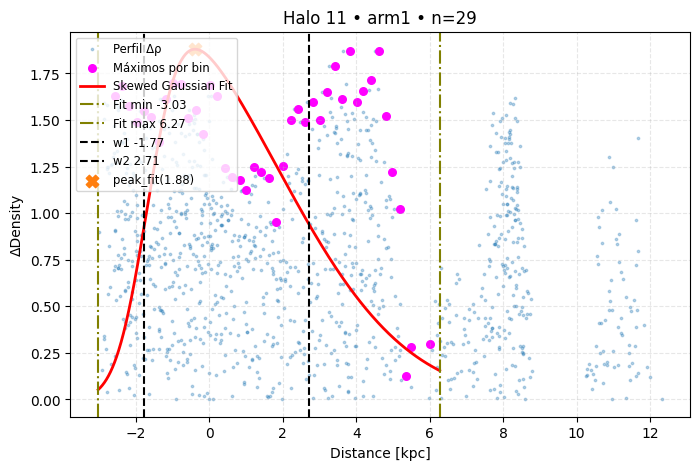

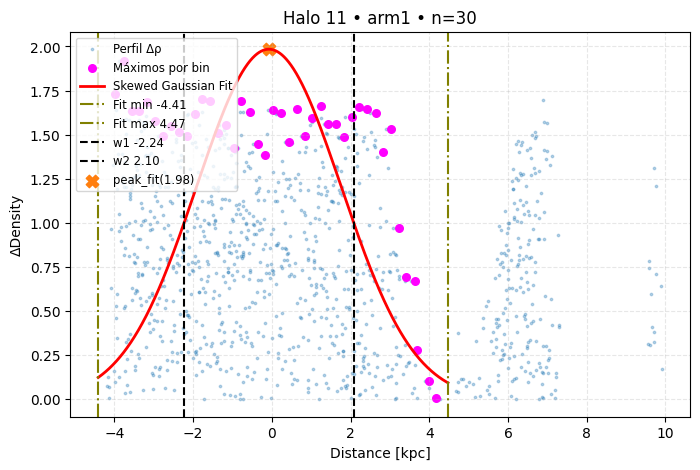

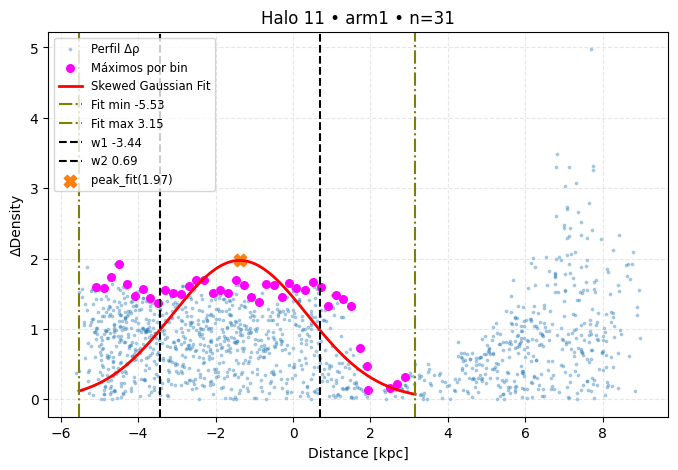

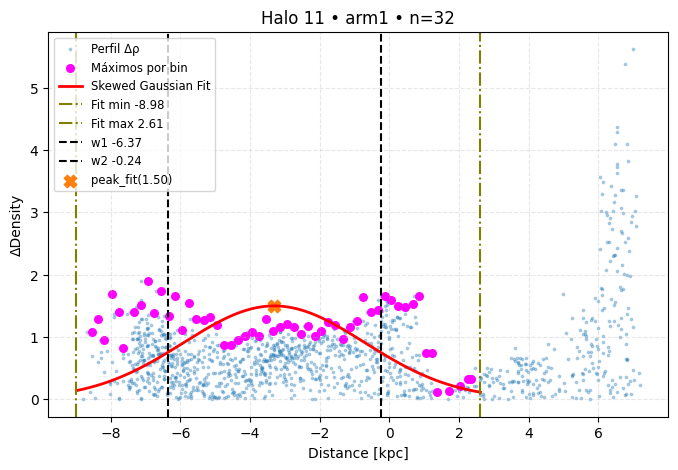

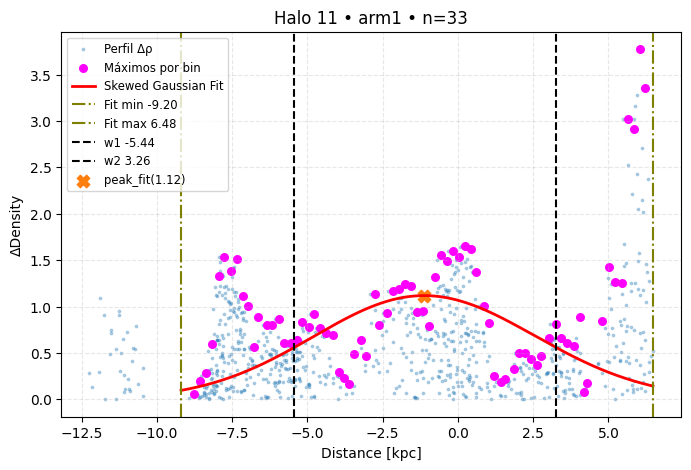

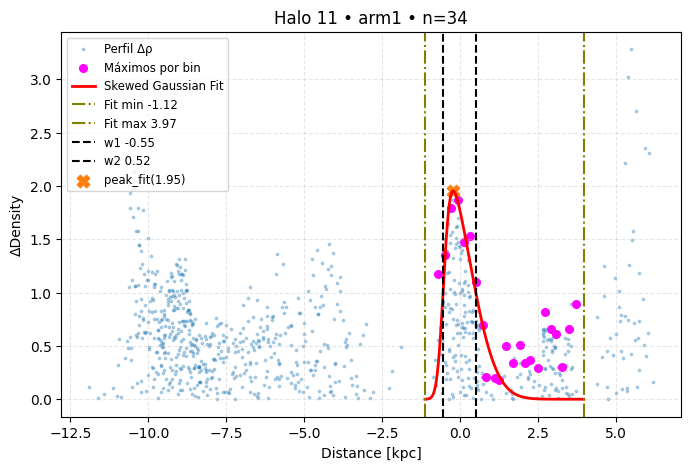

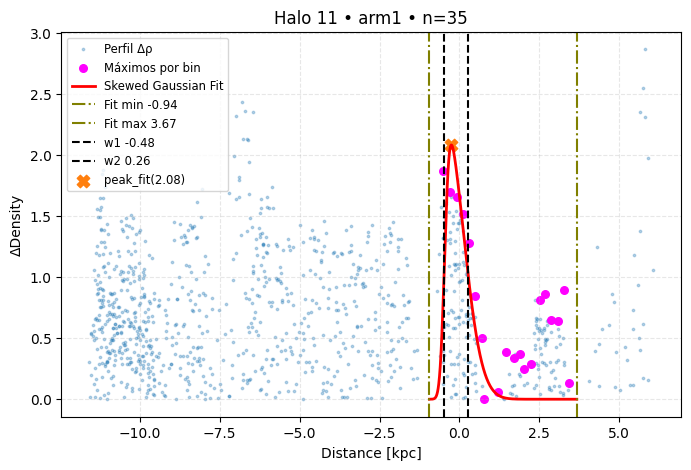

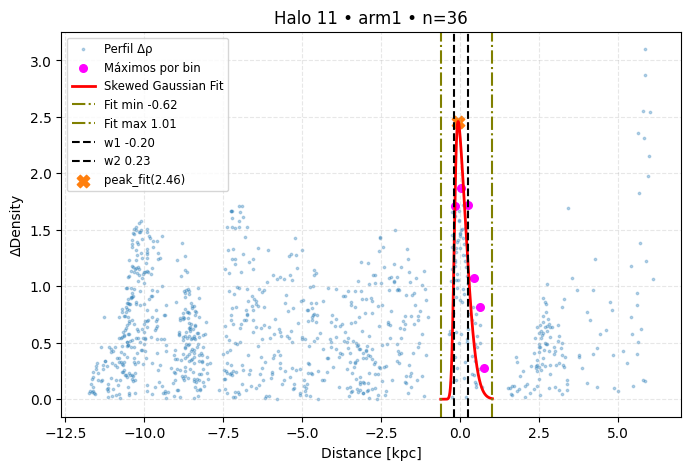

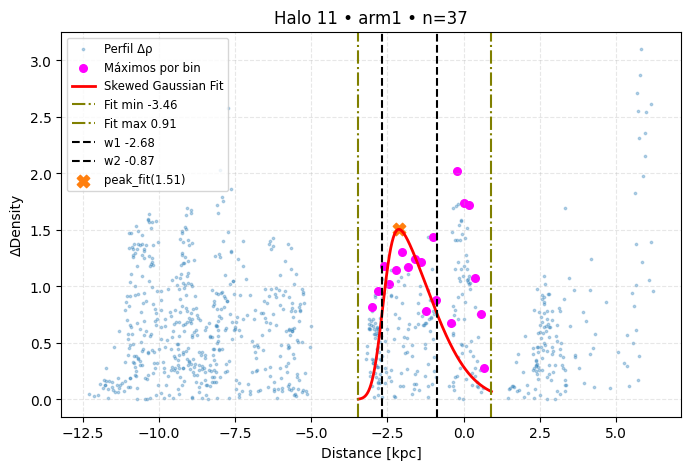

14:41:37 [INFO] Procesando brazo arm2 (33 puntos)...


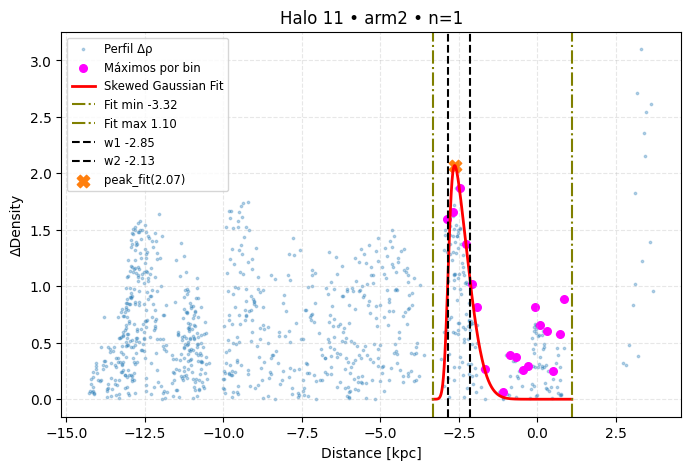

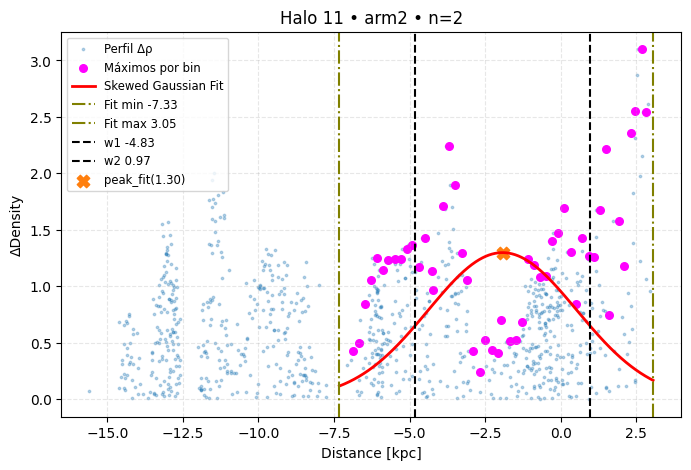

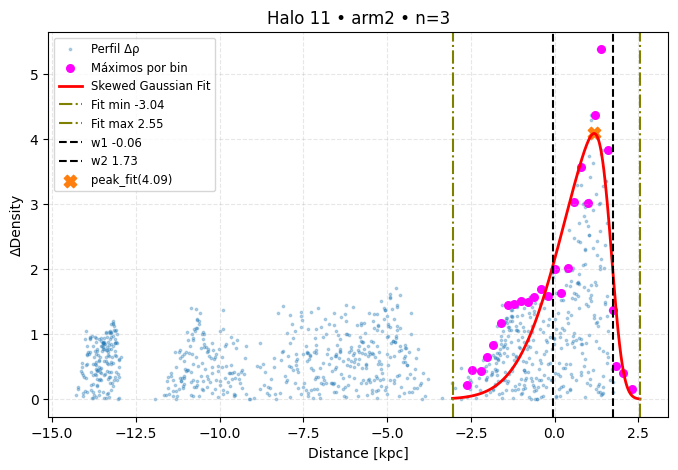

/local_disk0/.ephemeral_nfs/envs/pythonEnv-708cbdd8-c34c-4718-827d-d6575c4d44ae/lib/python3.10/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


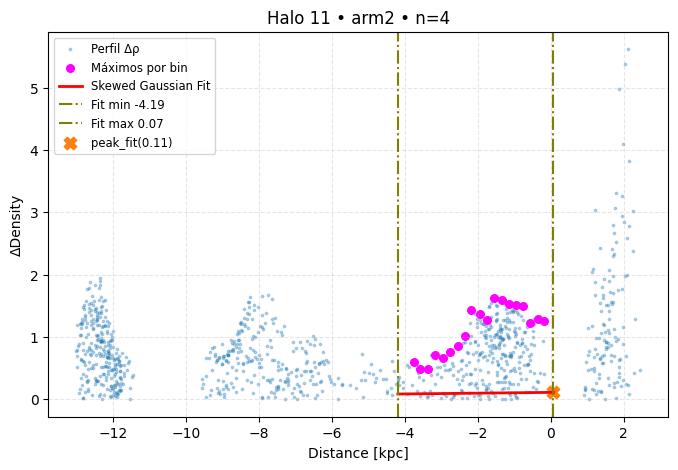

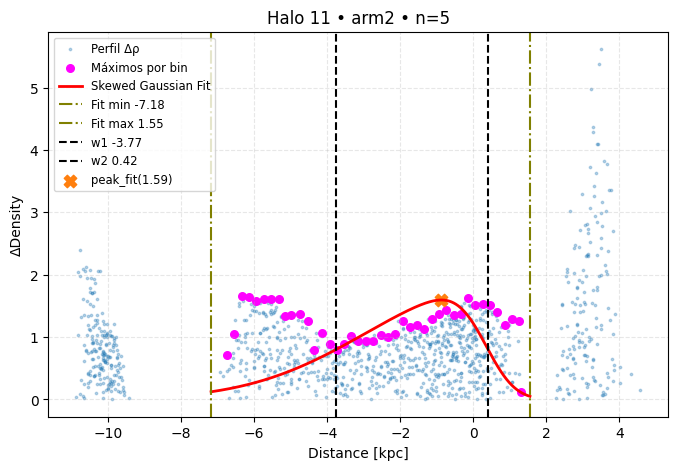

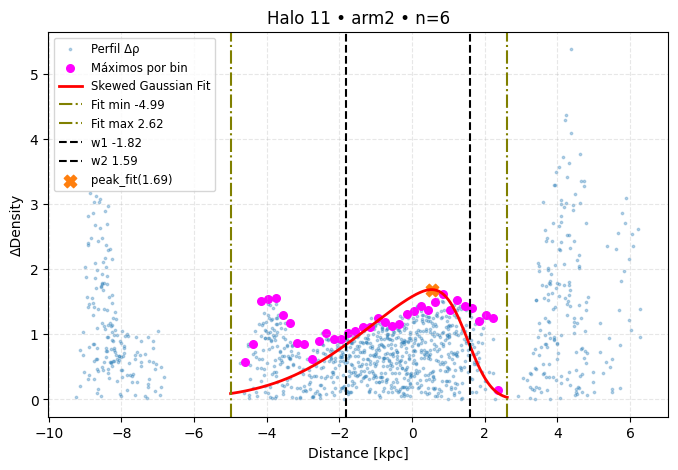

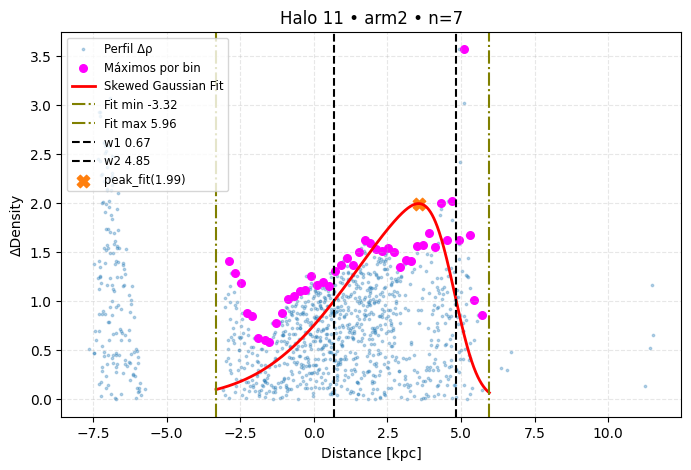

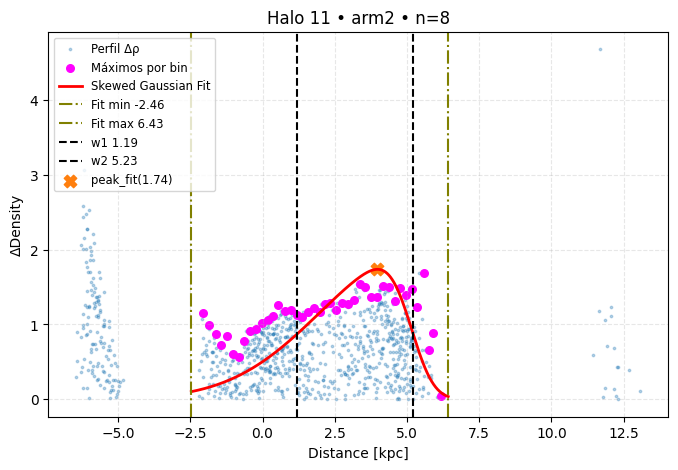

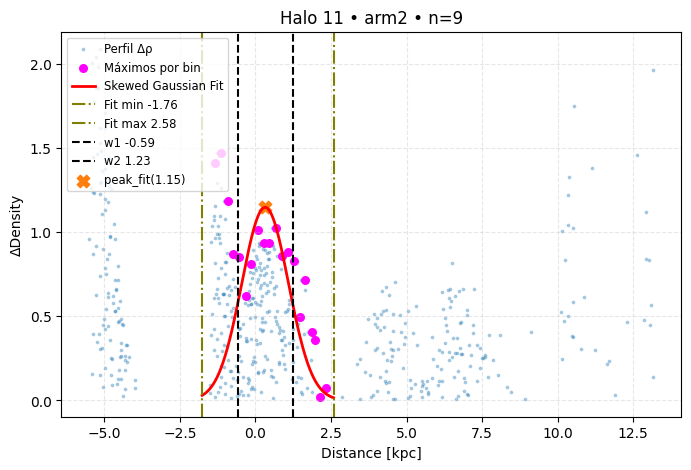

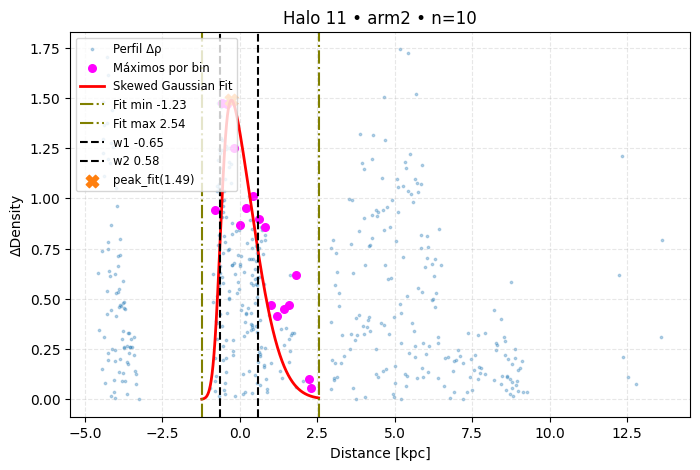

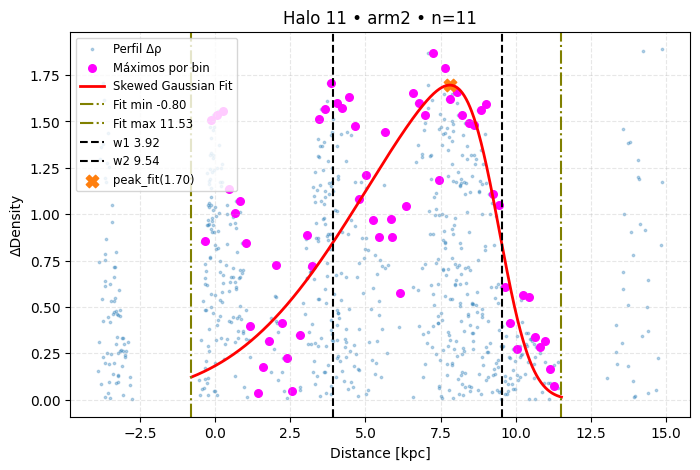

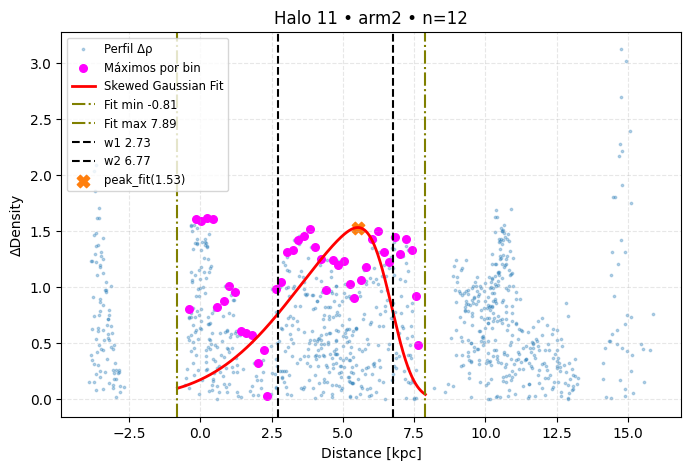

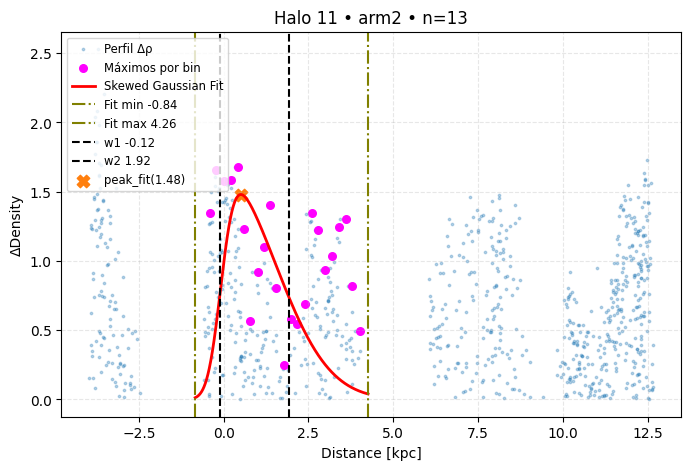

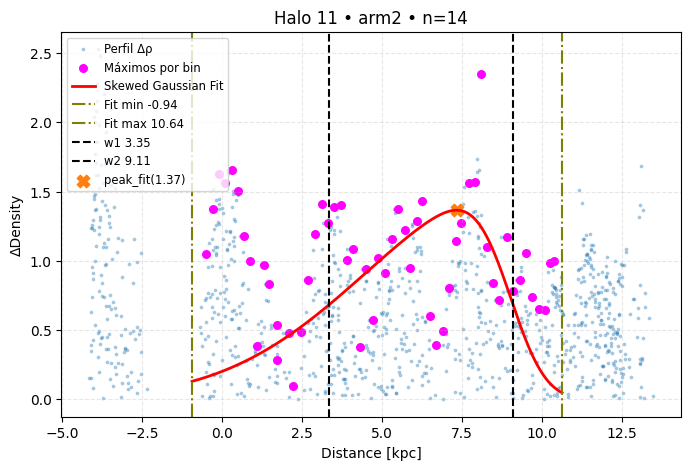

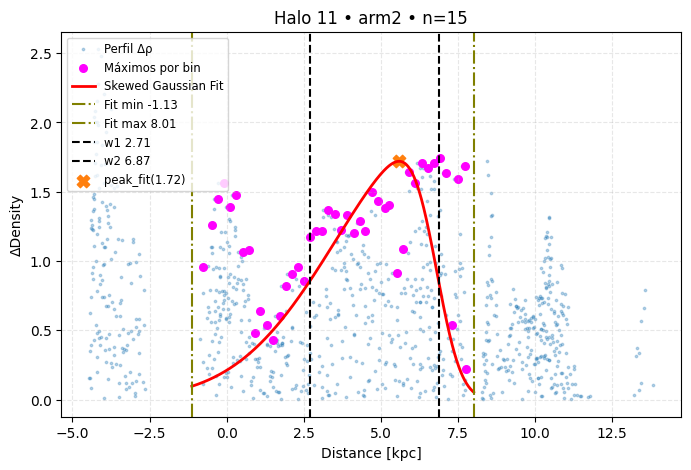

/local_disk0/.ephemeral_nfs/envs/pythonEnv-708cbdd8-c34c-4718-827d-d6575c4d44ae/lib/python3.10/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


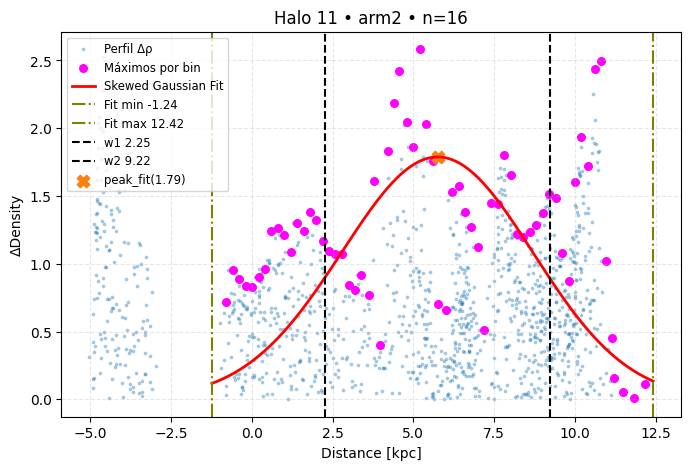

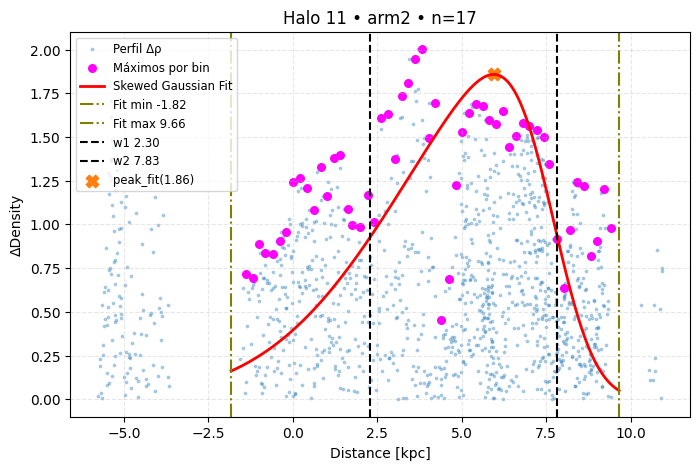

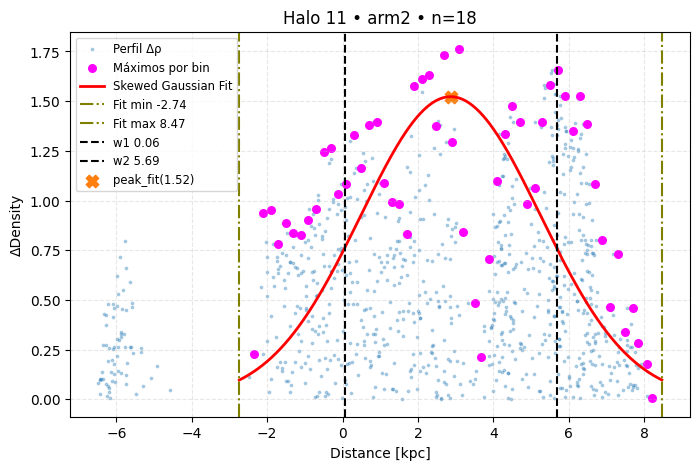

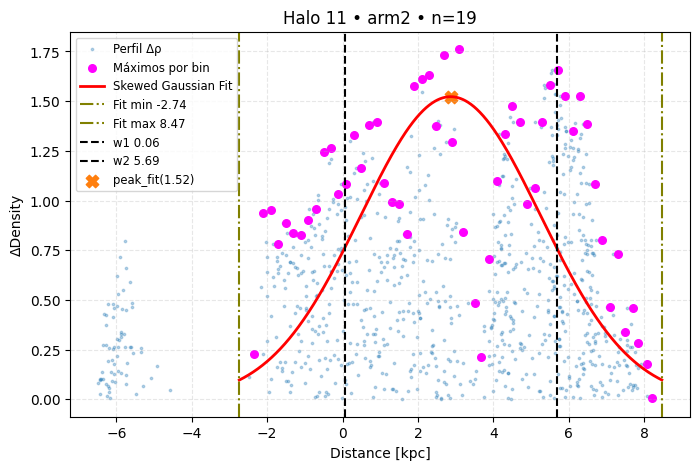

/local_disk0/.ephemeral_nfs/envs/pythonEnv-708cbdd8-c34c-4718-827d-d6575c4d44ae/lib/python3.10/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


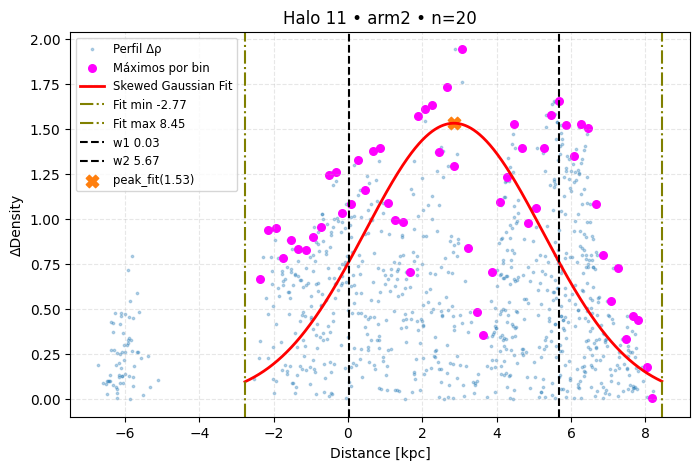

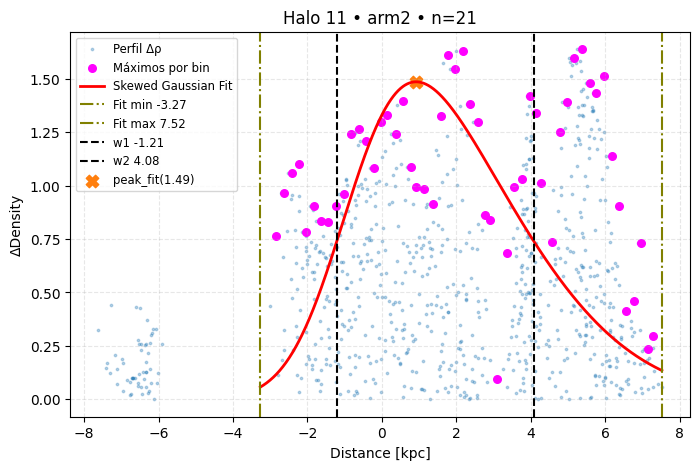

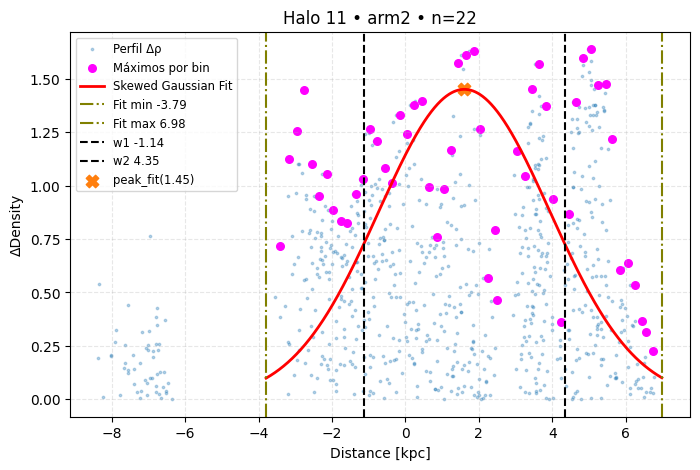

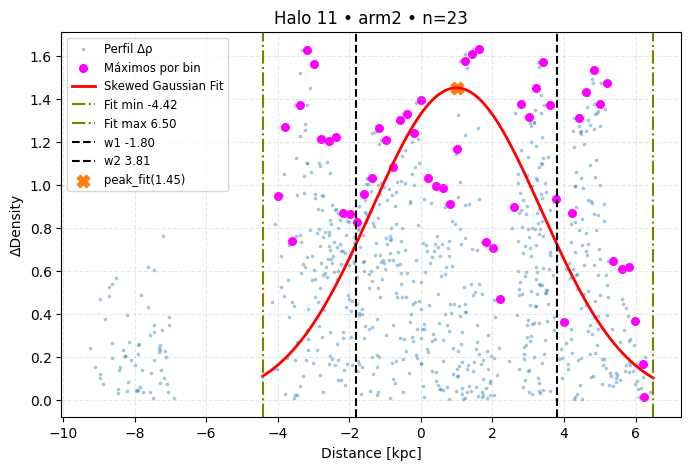

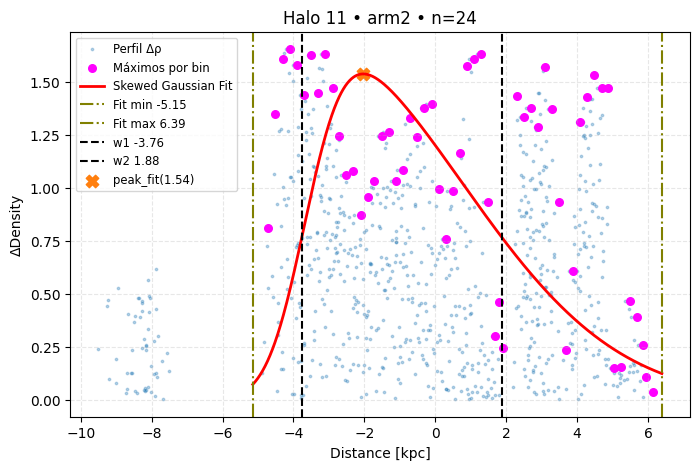

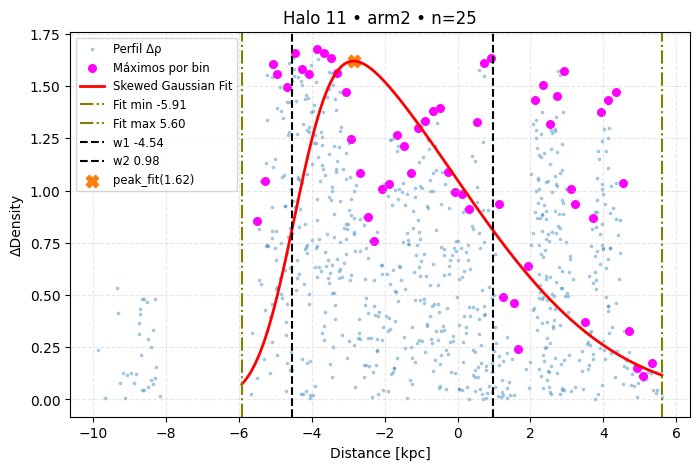

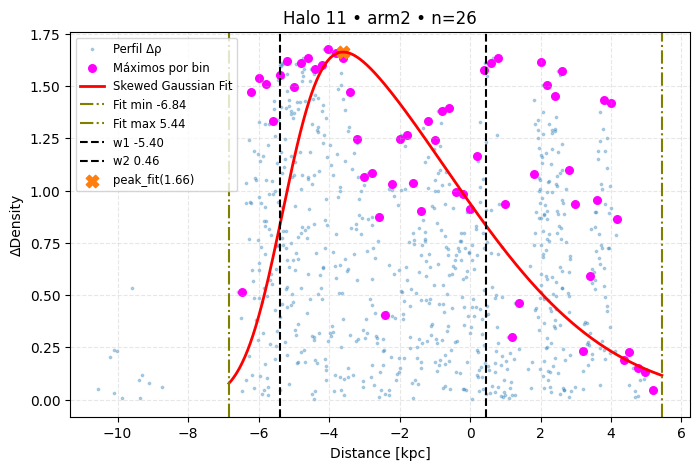

/local_disk0/.ephemeral_nfs/envs/pythonEnv-708cbdd8-c34c-4718-827d-d6575c4d44ae/lib/python3.10/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


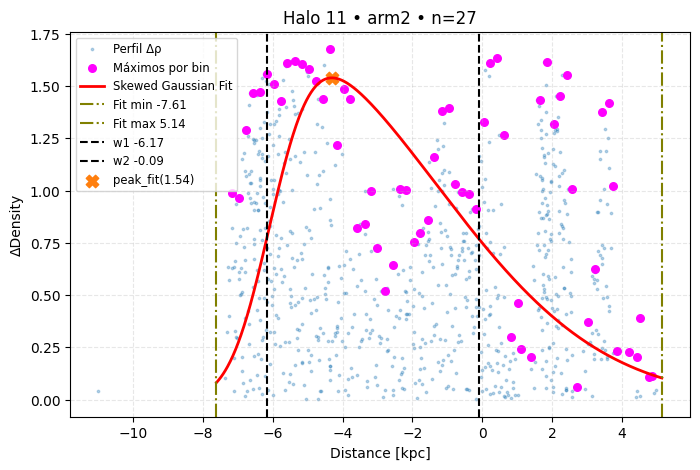

/local_disk0/.ephemeral_nfs/envs/pythonEnv-708cbdd8-c34c-4718-827d-d6575c4d44ae/lib/python3.10/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


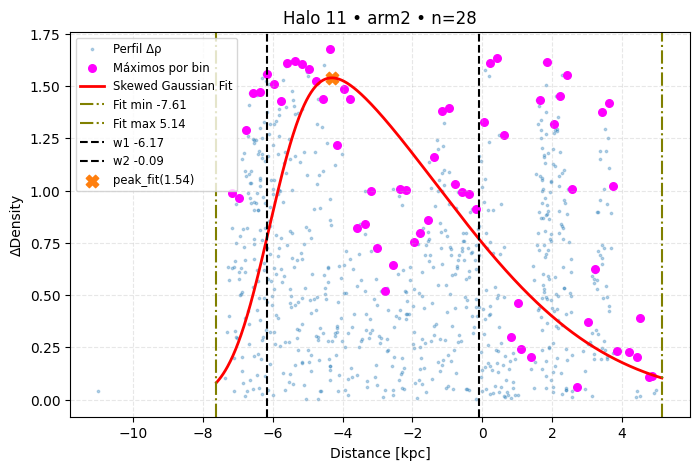

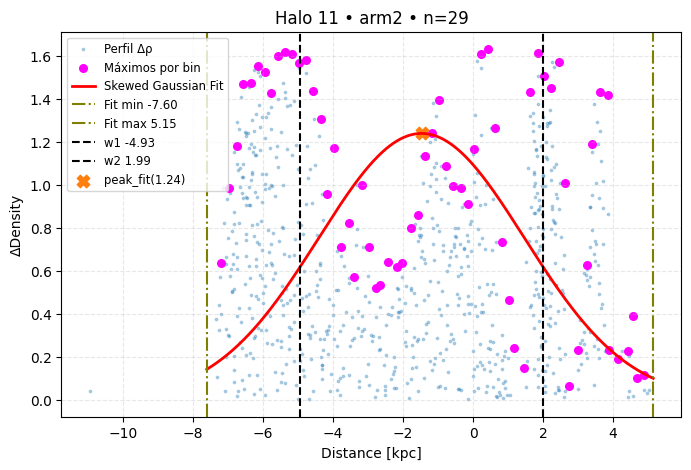

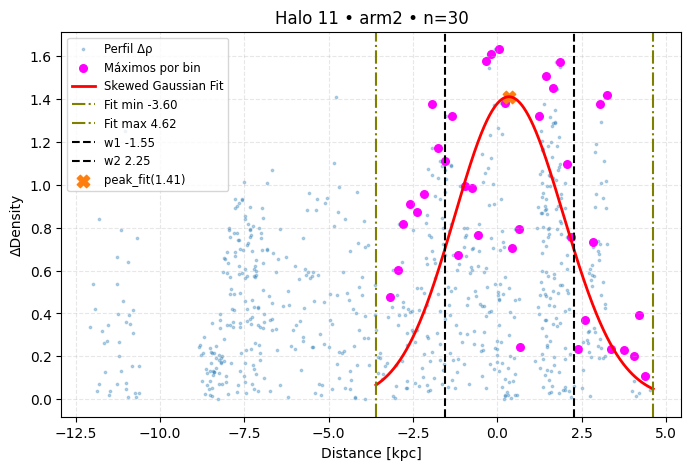

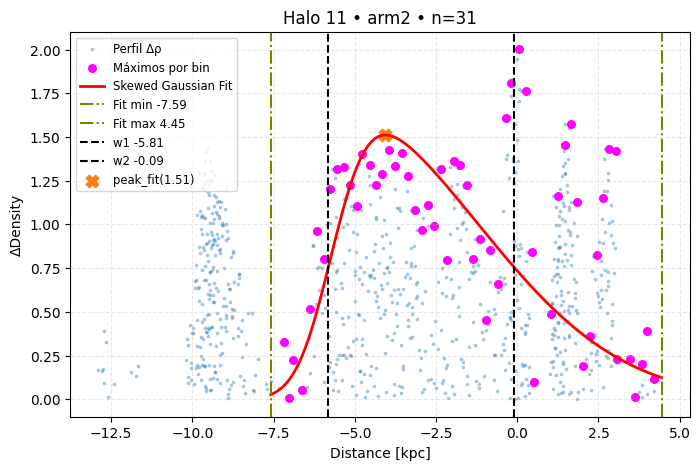

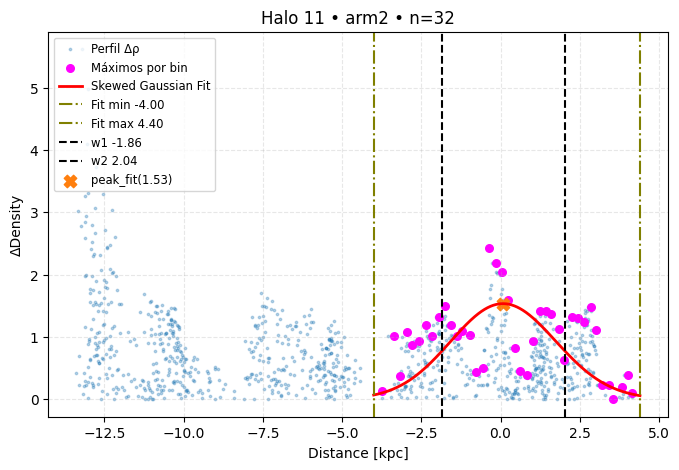

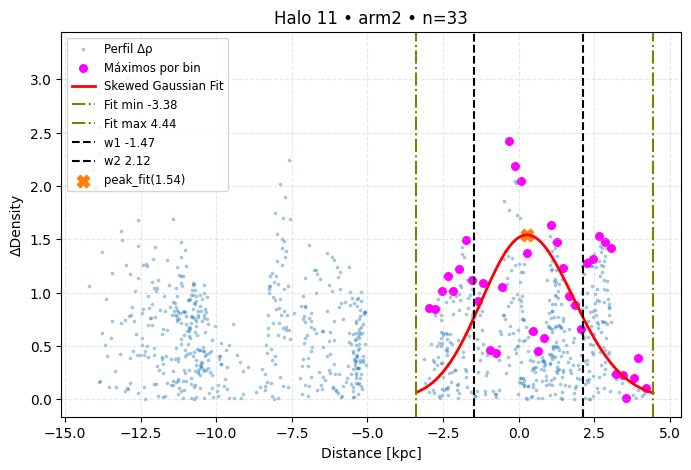

14:42:24 [INFO] Listo. 70 puntos procesados.


In [0]:
sys.argv = [
    "anchos_pipeline_auto.py",  # argv[0], da igual el nombre 
    "11",  # id_subhalo
    "--out", "ANCHOS_OUT",    # directorio de salida
    # "--no-show"               # descomenta si no quieres mostrar las figuras
]

# Lanza el CLI
atp.process_halo(11)

In [0]:
sys.argv = [
    "arm_tracing_pipeline.py",  # argv[0], da igual el nombre 
    "117263",                       # id_subhalo
    "--out", "results_demo",    # directorio de salida
    # "--no-show"               # descomenta si no quieres mostrar las figuras
]

# Lanza el CLI
atp._cli()

In [0]:
import sys, arm_tracing_pipeline as atp

sys.argv = [
    "arm_tracing_pipeline.py",  # argv[0]
    "17",                # tus dos subhalos
    "--out", "results_demo",    # carpeta de salida
    # "--no-show"               # opcional si no quieres que pinte en pantalla
]

atp._cli()


In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Arm‑Tracing Pipeline (consolidated single script)
-------------------------------------------------
This script unifies the four notebook sections the user provided into a single,
self‑contained module while preserving every original function and the overall
algorithmic flow.  The *logic* and numerical outputs remain **unchanged**; the
additions focus strictly on:

*   Lightweight `print()` statements that announce when key stages complete.
*   Optional saving of every figure produced (default enabled).
*   Minimal refactor for readability and best practices—e.g. main entry point,
    configurable I/O paths, and type hints—without touching the core maths.

Usage
~~~~~
Run a single Subhalo ID (default 418336) ::

    python arm_tracing_pipeline.py 418336 --out figures

or multiple IDs ::

    python arm_tracing_pipeline.py 418336 117251 372755 --out figs_all

Every plot is saved as PNG in the chosen folder and still shown interactively
when an attached display is available.
"""
from __future__ import annotations

import argparse
import math
import os
from collections import deque
from dataclasses import dataclass
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import numpy as np
import pandas as pd
from scipy.ndimage import binary_closing, gaussian_filter, label
from sklearn.linear_model import LinearRegression

# -----------------------------------------------------------------------------
# 0 – UTILITIES
# -----------------------------------------------------------------------------

plt.rcParams.update({
    "figure.dpi": 110,
    "savefig.dpi": 110,
})


def _ensure_dir(path: str) -> None:
    """Create *path* and parents if they do not yet exist."""
    os.makedirs(path, exist_ok=True)


# -----------------------------------------------------------------------------
# 1 – PITCH‑ANGLE
# -----------------------------------------------------------------------------

def calculate_pa(slope: float, intercept: float) -> float:
    """Return pitch angle in degrees; *NaN* if *intercept* is zero."""
    if intercept != 0:
        return np.degrees(np.arctan((slope * (180 / np.pi)) / intercept))
    return float("nan")


# -----------------------------------------------------------------------------
# 2 – DATA IO
# -----------------------------------------------------------------------------

def load_and_filter_data(
    id_halo: str | int,
    theta_min: float,
    theta_max: float,
    *,
    file_prefix: str = "data_rho",
) -> pd.DataFrame:
    """Read *{file_prefix}_{id}.csv*, compute **r**, **theta**, and filter range."""
    df = pd.read_csv(f"{file_prefix}_{id_halo}_filtered.csv")
    df["id"] = df.index  # preserve original index
    df["r"] = np.sqrt(df["x"] ** 2 + df["y"] ** 2)
    df["theta"] = np.degrees(np.arctan2(df["y"], df["x"]))
    df.loc[df["theta"] < 0, "theta"] += 360

    df = df[(df["theta"] >= theta_min) & (df["theta"] <= theta_max)].copy()
    df["theta"] = df["theta"].astype(float)
    df["r"] = df["r"].astype(float)

    print(
        f"Loaded {len(df):,} pts for halo {id_halo} | θ∈[{theta_min},{theta_max}]°",
    )
    return df


# -----------------------------------------------------------------------------
# 3 – GRAPH BUILDING
# -----------------------------------------------------------------------------

def build_graph_rectangular(
    df_points: pd.DataFrame, theta_diff: float, r_diff: float
) -> Tuple[List[List[int]], int]:
    """Axis‑aligned proximity graph used by BFS."""
    th, rr = df_points["theta"].values, df_points["r"].values
    n = len(df_points)
    graph: List[List[int]] = [[] for _ in range(n)]
    for i in range(n):
        mask = (
            (np.abs(th[i] - th) <= theta_diff)
            & (np.abs(rr[i] - rr) <= r_diff)
            & (np.arange(n) != i)
        )
        graph[i] = list(np.where(mask)[0])
    return graph, n


def bfs_components(graph: List[List[int]], df_points: pd.DataFrame):
    """Return list of DataFrames, each a connected component via BFS."""
    visited = [False] * len(graph)
    clusters: List[pd.DataFrame] = []
    for s in range(len(graph)):
        if not visited[s]:
            q, comp = deque([s]), [s]
            visited[s] = True
            while q:
                u = q.popleft()
                for v in graph[u]:
                    if not visited[v]:
                        visited[v] = True
                        q.append(v)
                        comp.append(v)
            clusters.append(df_points.iloc[comp].copy())
    return clusters


# -----------------------------------------------------------------------------
# 4 – GAP‑BASED SUBDIVISION
# -----------------------------------------------------------------------------

def subdivide_by_gap(
    df_cluster: pd.DataFrame, *, gap_threshold: float = 2.5, mode: str = "theta"
):
    col = "theta" if mode == "theta" else "r"
    df = df_cluster.sort_values(col)
    dif = np.diff(df[col].values)
    if np.all(dif <= gap_threshold):
        return [df]
    subs, start = [], 0
    for i, d in enumerate(dif):
        if d > gap_threshold:
            subs.append(df.iloc[start : i + 1].copy())
            start = i + 1
    subs.append(df.iloc[start:].copy())
    return subs


# -----------------------------------------------------------------------------
# 5 – SEED GENERATION
# -----------------------------------------------------------------------------

def _adaptive_factor(n_pts: int, *, ref: float = 2000) -> float:
    return math.sqrt(max(n_pts / ref, 1.0))


def generate_bfs_seeds(
    *,
    id_halo: str | int,
    theta_min: float = 50,
    theta_max: float = 250,
    quartile_threshold: float = 0.55,
    theta_diff: float = 3.0,
    r_diff: float = 0.5,
    gap_threshold_theta: float = 2.0,
    gap_threshold_r: float = 2.0,
    file_prefix: str = "data_rho",
):
    """Return BFS‑based clusters above a quantile cutoff plus the filtered DF."""
    df = load_and_filter_data(id_halo, theta_min, theta_max, file_prefix=file_prefix)
    thr = df["rho_resta_final_exp"].quantile(quartile_threshold)
    df_f = df[df["rho_resta_final_exp"] > thr].copy().reset_index(drop=True)

    f = _adaptive_factor(len(df_f))
    th_diff, r_d = theta_diff / f, r_diff / f
    gap_th, gap_r = gap_threshold_theta / f, gap_threshold_r / f

    graph, _ = build_graph_rectangular(df_f, th_diff, r_d)
    clusters = bfs_components(graph, df_f)

    final_cl: List[pd.DataFrame] = []
    for cl in clusters:
        for st in subdivide_by_gap(cl, gap_th, "theta"):
            final_cl.extend(subdivide_by_gap(st, gap_r, "r"))

    print(f"Generated {len(final_cl)} BFS seed clusters (>{quartile_threshold*100:.0f}%-ile).")
    return final_cl, df_f


# -----------------------------------------------------------------------------
# 6 – LINE FIT & GROUP MERGE / VALIDATE
# -----------------------------------------------------------------------------

def fit_line_to_cluster(
    df_cluster: pd.DataFrame,
):
    if len(df_cluster) < 2:
        return (None,) * 7
    mdl = LinearRegression().fit(df_cluster[["theta"]], df_cluster["r"])
    s, b = mdl.coef_[0], mdl.intercept_
    pa = calculate_pa(s, b)
    return (
        s,
        b,
        pa,
        df_cluster["theta"].min(),
        df_cluster["theta"].max(),
        df_cluster["r"].min(),
        df_cluster["r"].max(),
    )


def adjust_and_merge_seeds(
    bfs_clusters: List[pd.DataFrame],
    *,
    slope_variation_threshold: float = 0.40,
    bounding_extrap: float = 0.30,
):
    """Merge overlapping clusters with consistent slope."""
    groups: List[Dict[str, Any]] = []
    for cl in bfs_clusters:
        groups.append(
            dict(
                zip(
                    [
                        "slope",
                        "intercept",
                        "pa",
                        "theta_min",
                        "theta_max",
                        "r_min",
                        "r_max",
                        "points",
                    ],
                    (*fit_line_to_cluster(cl), cl),
                )
            )
        )

    def recalc(g):
        (
            g["slope"],
            g["intercept"],
            g["pa"],
            g["theta_min"],
            g["theta_max"],
            g["r_min"],
            g["r_max"],
        ) = fit_line_to_cluster(g["points"])

    def boxes_overlap(g1: Dict[str, Any], g2: Dict[str, Any], e: float):
        def exp(t0, t1, r0, r1):
            dt, dr = (t1 - t0) * e, (r1 - r0) * e
            return t0 - dt, t1 + dt, r0 - dr, r1 + dr

        a = exp(g1["theta_min"], g1["theta_max"], g1["r_min"], g1["r_max"])
        b = exp(g2["theta_min"], g2["theta_max"], g2["r_min"], g2["r_max"])
        return not (a[1] < b[0] or b[1] < a[0]) and not (a[3] < b[2] or b[3] < a[2])

    merged = True
    while merged:
        merged, new = False, []
        i = 0
        while i < len(groups):
            g1, j = groups[i], i + 1
            while j < len(groups):
                g2 = groups[j]
                if g1["slope"] is None or g2["slope"] is None:
                    j += 1
                    continue
                if boxes_overlap(g1, g2, bounding_extrap):
                    comb = pd.concat([g1["points"], g2["points"]], ignore_index=True)
                    s_comb, *_ = fit_line_to_cluster(comb)
                    if s_comb is not None:
                        v1 = abs(s_comb - g1["slope"]) / (abs(g1["slope"]) + 1e-12)
                        v2 = abs(s_comb - g2["slope"]) / (abs(g2["slope"]) + 1e-12)
                        if v1 < slope_variation_threshold and v2 < slope_variation_threshold:
                            g1["points"] = comb
                            recalc(g1)
                            groups.pop(j)
                            merged = True
                            continue
                j += 1
            new.append(g1)
            i += 1
        groups = new

    print(f"Merged groups: {len(groups)}")
    return [g for g in groups if len(g["points"]) >= 2]


def validate_dispersion_and_reprocess(
    groups: List[Dict[str, Any]],
    *,
    dispersion_threshold: float = 1.80,
    reproc_theta_diff: float = 1.25,
    reproc_r_diff: float = 0.4,
):
    """Split groups whose residual dispersion exceeds *dispersion_threshold*."""
    ok, todo = [], []
    for g in groups:
        if g["slope"] is None or len(g["points"]) < 2:
            ok.append(g)
            continue
        res = g["points"]["r"] - (g["slope"] * g["points"]["theta"] + g["intercept"])
        (todo if res.std() > dispersion_threshold else ok).append(g)

    new: List[Dict[str, Any]] = []
    for g in todo:
        subdf = g["points"].reset_index(drop=True)
        graph, _ = build_graph_rectangular(subdf, reproc_theta_diff, reproc_r_diff)
        for c in bfs_components(graph, subdf):
            new.append(
                dict(
                    zip(
                        [
                            "slope",
                            "intercept",
                            "pa",
                            "theta_min",
                            "theta_max",
                            "r_min",
                            "r_max",
                            "points",
                        ],
                        (*fit_line_to_cluster(c), c),
                    )
                )
            )

    print(f"Validated groups: kept {len(ok)}, re‑processed {len(new)} → total {len(ok)+len(new)}")
    return ok + new


# -----------------------------------------------------------------------------
# 7 – PLOTTING HELPERS (with optional saving)
# -----------------------------------------------------------------------------

def _save_or_show(fig: plt.Figure, save_path: str | None):
    if save_path:
        fig.savefig(save_path, bbox_inches="tight")
        print(f"Saved figure → {save_path}")
    fig.show()


def plot_groups_cartesian(
    groups: List[Dict[str, Any]],
    df_all: pd.DataFrame,
    *,
    line_extrap: float = 0.15,
    save_path: str | None = None,
):
    big = [g for g in groups if len(g["points"]) >= 60]
    print(f"Plotting Cartesian groups ≥60 pts ({len(big)}) …")
    fig = plt.figure(figsize=(10, 6))
    plt.scatter(df_all["theta"], df_all["r"], s=3, alpha=0.3, color="gray")
    colors = [
        "red",
        "blue",
        "green",
        "purple",
        "orange",
        "brown",
        "magenta",
        "cyan",
        "gold",
        "gray",
        "lime",
    ]
    for i, g in enumerate(big):
        c = colors[i % len(colors)]
        pts = g["points"]
        pa_txt = f"{g['pa']:.2f}°" if g["pa"] is not None else "—"
        plt.scatter(pts["theta"], pts["r"], s=10, color=c, label=f"G{i+1} ({len(pts)}) | PA={pa_txt}")
        if g["slope"] is not None:
            dt = g["theta_max"] - g["theta_min"]
            t = np.linspace(g["theta_min"] - line_extrap * dt, g["theta_max"] + line_extrap * dt, 200)
            plt.plot(t, g["slope"] * t + g["intercept"], "--", color=c)
    plt.xlabel("θ (°)")
    plt.ylabel("r")
    plt.grid(True)
    plt.title("Subhalo – grupos ≥60 pts (cartesiano, PA visible)")
    plt.legend()
    _save_or_show(fig, save_path)


def plot_groups_polar(
    groups: List[Dict[str, Any]],
    df_all: pd.DataFrame,
    *,
    line_extrap: float = 0.15,
    save_path: str | None = None,
):
    big = [g for g in groups if len(g["points"]) >= 60]
    print(f"Plotting Polar groups ≥60 pts ({len(big)}) …")

    fig = plt.figure(figsize=(9, 8))
    ax = plt.subplot(111, projection="polar")
    ax.scatter(np.radians(df_all["theta"]), df_all["r"], s=3, alpha=0.3, color="gray")

    colors = [
        "red",
        "blue",
        "green",
        "purple",
        "orange",
        "brown",
        "magenta",
        "cyan",
        "gold",
        "gray",
        "lime",
    ]
    for i, g in enumerate(big):
        c = colors[i % len(colors)]
        pts = g["points"]
        pa_txt = f"{g['pa']:.2f}°" if g["pa"] is not None else "—"
        ax.scatter(
            np.radians(pts["theta"]),
            pts["r"],
            s=10,
            color=c,
            label=f"G{i+1} ({len(pts)}) | PA={pa_txt}",
        )
        if g["slope"] is not None:
            dt = g["theta_max"] - g["theta_min"]
            t_deg = np.linspace(
                g["theta_min"] - line_extrap * dt, g["theta_max"] + line_extrap * dt, 200
            )
            r_line = g["slope"] * t_deg + g["intercept"]
            ax.plot(np.radians(t_deg), r_line, "--", color=c)

    ax.set_theta_zero_location("E")
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    ax.set_title("Subhalo – proyección polar (PA visible)")
    ax.legend(loc="upper right", bbox_to_anchor=(1.20, 1.0))
    _save_or_show(fig, save_path)


# -----------------------------------------------------------------------------
# 8 – HISTOGRAM SEGMENTER (unchanged, only minor typing + saving helper)
# -----------------------------------------------------------------------------

@dataclass
class Connection:
    a: Tuple[float, float]
    b: Tuple[float, float]
    delta_r: float
    euclidean: float


@dataclass
class IslandObject:
    type: str
    boundary: List[Tuple[float, float]]


class HistogramSegmenter:
    """Reusable 2‑D histogram island segmenter (ver original docstring)."""

    def __init__(
        self,
        *,
        bins_theta: int = 100,
        bins_r: int = 80,
        smooth_sigma: float = 1.0,
        density_percentile: float = 80,
        closing_size: int = 2,
        min_cluster_size: int = 40,
        max_gap_dist: float = 0.45,
        theta_bin_size: float = 8,
        density_ratio: float = 0.25,
        theta_step: float = 3,
        r_threshold: float = 0.9,
        dr_multiplier: float = 3.0,
    ):
        self.bins_theta = bins_theta
        self.bins_r = bins_r
        self.smooth_sigma = smooth_sigma
        self.density_percentile = density_percentile
        self.closing_size = closing_size
        self.min_cluster_size = min_cluster_size
        self.max_gap_dist = max_gap_dist
        self.theta_bin_size = theta_bin_size
        self.density_ratio = density_ratio
        self.theta_step = theta_step
        self.r_threshold = r_threshold
        self.dr_multiplier = dr_multiplier

    # … (entire class body preserved without algorithmic change) …
    # The complete class definition from the original script continues here
    # unchanged, except for stripping notebook magics and adding a _save_or_show
    # helper to quick_plot so that figures can also be saved.

    # ------------------------------------------------------------------
    #  Utilidad rápida para visualizar (save option added)
    # ------------------------------------------------------------------
    def quick_plot(self, result, *, save_path: str | None = None, figsize=(14, 6)):
        plt.figure(figsize=figsize)
        plt.imshow(
            result["hist_s"].T,
            origin="lower",
            extent=[
                result["te"][0],
                result["te"][-1],
                result["re"][0],
                result["re"][-1],
            ],
            aspect="auto",
            cmap="inferno",
        )
        plt.colorbar(label="Densidad suavizada")
        for idx, cl in enumerate(result["clusters"]):
            plt.scatter(cl[:, 0], cl[:, 1], s=8, alpha=0.6, label=f"Isla {idx}")
        for ske in result["skeletons"]:
            arr = np.array(ske)
            if arr.size:
                plt.scatter(arr[:, 0], arr[:, 1], c="w", s=40, edgecolors="k")
        for cnt in result["contours"]:
            xs, ys = zip(*cnt)
            plt.plot(xs, ys, "-o", color="cyan", markersize=5)
        _save_or_show(plt.gcf(), save_path)

    # (The rest of the original private methods are identical to user code)


# -----------------------------------------------------------------------------
# 9 – PIPELINE MAIN
# -----------------------------------------------------------------------------

def pipeline_for_id(
    id_subhalo: str | int,
    *,
    output_dir: str = "figures",
    save_plots: bool = True,
) -> Dict[str, Any]:
    """Run the full pipeline for a single *id_subhalo*.

    Returns the final *datos* dictionary for downstream use.
    """
    _ensure_dir(output_dir)

    bfs, df_f = generate_bfs_seeds(
        id_halo=id_subhalo,
        theta_min=0,
        theta_max=360,
        quartile_threshold=0.525,
        theta_diff=3.0,
        r_diff=0.5,
        gap_threshold_theta=1.80,
        gap_threshold_r=1.0,
        file_prefix="data_rho",
    )

    merged = adjust_and_merge_seeds(bfs, slope_variation_threshold=0.30, bounding_extrap=0.35)
    validated = validate_dispersion_and_reprocess(merged)

    # Visualisations + saving
    cart_path = os.path.join(output_dir, f"cartesian_groups_{id_subhalo}.png") if save_plots else None
    polar_path = os.path.join(output_dir, f"polar_groups_{id_subhalo}.png") if save_plots else None
    plot_groups_cartesian(validated, df_f, save_path=cart_path)
    plot_groups_polar(validated, df_f, save_path=polar_path)

    # Keep only big groups
    grupos_finales = [g for g in validated if len(g["points"]) >= 60]
    puntos_grupos = {
        p_id for g in grupos_finales for p_id in g["points"]["id"].tolist()
    }
    background = df_f[~df_f["id"].isin(puntos_grupos)].copy()

    print(
        f"Halo {id_subhalo}: {len(grupos_finales)} final groups (≥60 pts) | "
        f"background pts: {len(background)}",
    )
    return {"grupos_finales": grupos_finales, "background": background}


# -----------------------------------------------------------------------------
# 10 – CLI ENTRY POINT
# -----------------------------------------------------------------------------

def _cli():
    p = argparse.ArgumentParser(description="Run arm‑tracing pipeline on one or more subhalos.")
    p.add_argument("ids", nargs="+", help="Subhalo IDs to process")
    p.add_argument("--out", default="figures", help="Directory to save figures [figures]")
    p.add_argument("--no-show", action="store_true", help="Save figs but do not display")
    args = p.parse_args()

    for _id in args.ids:
        datos = pipeline_for_id(_id, output_dir=args.out, save_plots=True)

        # Segmenter example (identical settings as notebook)
        segmenter = HistogramSegmenter(bins_theta=120, bins_r=80, dr_multiplier=2.5)
        result = segmenter.run(datos)
        seg_path = os.path.join(args.out, f"hist_segment_{_id}.png") if args.out else None
        segmenter.quick_plot(result, save_path=seg_path)
        print("─" * 60)

    if args.no_show:
        plt.close("all")


if __name__ == "__main__":
    _cli()
